### Imports

In [1]:
#!/usr/bin/env python3

from functools import wraps
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, rand
import numdifftools as nd
import picos as pc
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import time

plt.style.use("default")

### Runtime

In [2]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [3]:
#name_of_dataset = 'Angle'
name_of_dataset = 'CShape'
#name_of_dataset = 'Sshape'

dataset = loadmat("../Dataset/" + name_of_dataset + '.mat')
# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

#### Mean of dataset

In [4]:
num_of_train_datasets = 4

pos_cell_1 = np.zeros((1000, num_of_train_datasets))
pos_cell_2 = np.zeros((1000, num_of_train_datasets))
vel_cell_1 = np.zeros((1000, num_of_train_datasets))
vel_cell_2 = np.zeros((1000, num_of_train_datasets))

print(len(dataset['demos'][0,0][0,0][0][0]))

# Concatenating the dataseries of position and velocities
for i in range(0, num_of_train_datasets):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2]

    pos_cell_1[:, i] = position_dataseries[0]
    pos_cell_2[:, i] = position_dataseries[1]
    vel_cell_1[:, i] = velocity_dataseries[0]
    vel_cell_2[:, i] = velocity_dataseries[1]

x_train_1 = pos_cell_1.mean(axis=1)
x_train_2 = pos_cell_2.mean(axis=1)
y_train_1 = vel_cell_1.mean(axis=1)
y_train_2 = vel_cell_2.mean(axis=1)

# Defines the position and velocity measurements
x_train = np.array([x_train_1, x_train_2])
y_train = np.array([y_train_1, y_train_2])

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later
time_step = dataset['dt'][0,0]

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1] 

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1)
time_series = np.cumsum(concatenate)
num_of_timesteps = len_of_dataseries
num_of_test_datasets = num_of_demos - num_of_train_datasets

# Intial starting point for the simulated trajectory using learnt model
init_condition = dataset['demos'][0,5][0,0][0][:, 0]

1000


#### Plot dataset (state trajectory with velocities as arrows)

C:\Users\vilde\AppData\Local\Temp\ipykernel_27724\1901655976.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dataset.show()


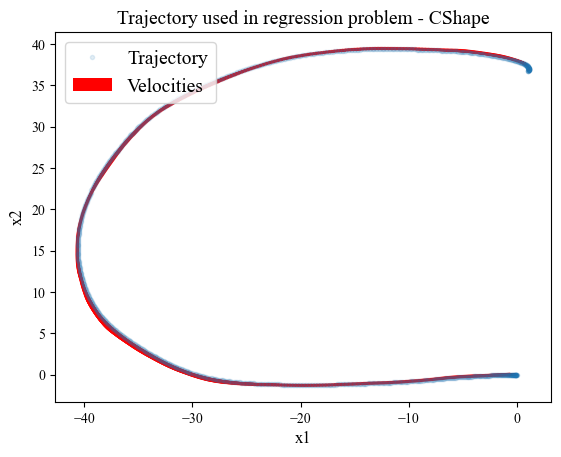

In [5]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

fig_dataset = plt.figure(1)
plt.title('Trajectory used in regression problem - ' + name_of_dataset, fontsize=14)
plt.plot(x_train[0,:], x_train[1,:], '.', alpha = 0.12)
plt.quiver(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:], color = 'red', scale = 700)
plt.xlabel('x1', fontsize =12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Velocities'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_dataset.show()
#plt.savefig("../src/figures_plot/lasa_datatset.eps", format ="eps")

axes = plt.gca() #gca = get current axes, from my last plot

### Vector-valued RFF for Gaussian Separable Kernel

In [6]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, d, dim):
    psi = psi_vector(x, w, b, d)
    return np.kron(psi, np.eye(dim))

def phi(x, w, b, N, d, dim):
    phi = np.zeros((dim*N, dim*d))
    for i in range(0, N):
        psi = capital_psi(x[:,i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

#### Psi derivative

In [7]:
def psi_derivative(x, w, b):
    return np.sqrt(2) * (-np.sin(w.T@x + b)) * w

#### Finding alpha without constraint

In [8]:
def alpha_approx(x, y, w, b, dim, d, lam, N):
    phi_ = phi(x, w, b, N, d, dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    d_param = pc.Constant('d', d)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_param', (d_param*dim_param, 1))
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

#### Alpha with contraction constraint

In [9]:
def alpha_approx_with_constraint(x, y, w, b, dim, d, lam, N, mu, constraint_points):
    phi_ = phi(x, w, b, N, d, dim)
    mu = mu * np.eye(dim)
    problem = pc.Problem()
    phi_param = pc.Constant('phi_', phi_)
    lam_param = pc.Constant('lam', lam)
    dim_param = pc.Constant('dim',dim)
    d_param = pc.Constant('d', d)
    mu_param = pc.Constant('mu', mu)
    constraint_points_param = pc.Constant('constraint_points', constraint_points)
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    y_reshaped_param = pc.Constant('y_reshaped', y_reshaped)
    alpha_var = pc.RealVariable('alpha_var', (d_param*dim_param, 1))
    # Creating constraints
    for i in range(constraint_points_param):
        constraint_index = i*np.int64(np.floor(len(x[0])/constraint_points))
        x_i = x[:, constraint_index]
        gradient = np.zeros(dim)
        for j in range(d):
            index = 2*j
            psi_derivative_param = pc.Constant('psi_derivative', psi_derivative(x_i, w[:, j], b[:, j]))
            jacobi = alpha_var[index:index+2] * psi_derivative_param.T
            gradient = gradient + 0.5 * (jacobi + jacobi.T)
        problem.add_constraint(gradient << mu_param)
    obj = ((phi_param * alpha_var) - y_reshaped_param).T * ((phi_param * alpha_var) - y_reshaped_param) + lam_param*(alpha_var.T * alpha_var)
    problem.set_objective('min', obj)
    problem.solve(solver='mosek')
    alpha_var = alpha_var.np.reshape((-1,))
    return alpha_var

#### Variables

In [10]:
sigma = 10
lambda_ = 0.1
num_of_constraint_points = 250
num_of_samples = 100

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi
mu = 0.0

#### Random Fourier Features & Regression

In [11]:
#alpha_rff = alpha_approx(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points)
alpha_rff_with_constraint = alpha_approx_with_constraint(x_train, y_train, w, b, dim_of_function, num_of_samples, lambda_, num_of_points, mu, num_of_constraint_points)

# Create callable function for learnt dynamics
# For alpha without constraints
#def learnt_model(t, x):
#    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_rff
#    return func

# For alpha with constraints
def learnt_model_with_constraint(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_rff_with_constraint
    return func

#### Solve differential equation using learnt model with solver_ivp

In [12]:
timespan = np.array([time_series[0],time_series[-1]])
t = np.linspace(time_series[0],time_series[-1], 1000)
data_series = solve_ivp(learnt_model_with_constraint, timespan, init_condition, t_eval = t).y

#### Plot simulated trajectory and streamslices for learnt model

In [13]:
# Get lower and upper bound for plotting from dataset figure
lower_bound_x1 = axes.get_xlim()[0]
upper_bound_x1 = axes.get_xlim()[1]
lower_bound_x2 = axes.get_ylim()[0]
upper_bound_x2 = axes.get_ylim()[1]

num_of_points_for_plot = 25

x1 = np.linspace(lower_bound_x1-5, upper_bound_x1, num_of_points_for_plot)
x2 = np.linspace(lower_bound_x2-5, upper_bound_x2, num_of_points_for_plot)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):
    # get velocities at each point with the learnt model
    Y_prime = learnt_model_with_constraint(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[0]
    v_learnt[i,j] = Y_prime[1]

#### Combined solution and vector field for learnt model

C:\Users\vilde\AppData\Local\Temp\ipykernel_27724\2566609994.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_learntmodel.show()


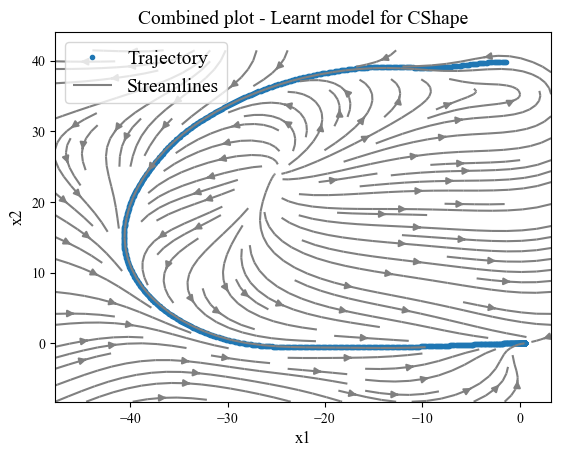

In [14]:
fig_learntmodel = plt.figure(2)
plt.title('Combined plot - Learnt model for ' + name_of_dataset, fontsize=14)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth=0.1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.legend(['Trajectory', 'Streamlines'], loc = "upper left" , frameon = True , prop ={'size': 14 } )
fig_learntmodel.show()
#plt.savefig("../src/figures_plot/lasa_learnt_model.eps", format ="eps")